In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
import pandas as pd

SQLalchemy is not installed. No support for SQL output.


In [3]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [4]:
sm = stepmodel.read_zip(training_folder + r'model/base/walk_model.zip'.format(scen=scenario))

read_hdf: 100%|████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 24.79it/s]


# ROUTE BREAKER: rail submodel

In [5]:
# add required fields
sm.links['length'] = sm.links['road_length']

In [6]:
rail = sm.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(['tram', 'subway', 'rail'])] 

In [7]:
rail.step_pt_pathfinder(
    broken_routes=True,
    broken_modes=False,
    route_column='route_short_name',
    mode_column='route_type',
    speedup=True
)

path_analysis: 100%|██████████████████████████████████████████████████████████| 29523/29523 [00:01<00:00, 23675.16it/s]


In [8]:
rail.pt_los.set_index(['origin', 'destination'])['pathfinder_session'].value_counts()

route_breaker    17423
best_path        12100
Name: pathfinder_session, dtype: int64

# MODE BREAKER

In [9]:
sm.links.drop(['index'], axis=1,inplace=True, errors='ignore')
sm.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=True,
    route_column='route_short_name'
)

path_analysis: 100%|██████████████████████████████████████████████████████████| 66094/66094 [00:03<00:00, 17609.79it/s]


# CONCATENATION

In [10]:
both = sm.copy()

In [11]:
both.pt_los = pd.concat(
    [sm.pt_los, rail.pt_los]
).drop_duplicates(subset=['path'])

In [12]:
both.pt_los.set_index(['origin', 'destination'])['pathfinder_session'].value_counts()

mode_breaker     66094
route_breaker    13386
Name: pathfinder_session, dtype: int64

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:26<00:00,  3.35s/it]


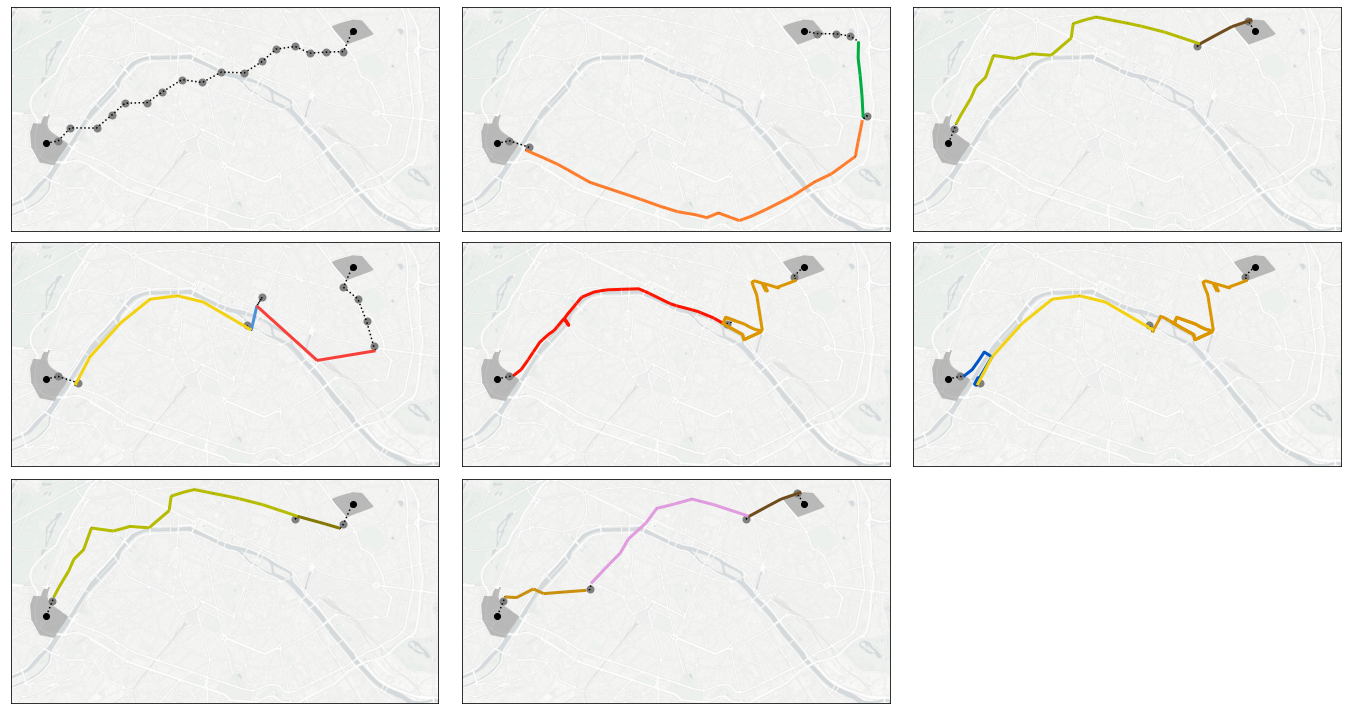

In [13]:
both.links['color'] = '#' + both.links['route_color']
origin, destination='zone_74',  'zone_105'
rows = 3
fig, axes = both.plot_separated_paths(
    origin, destination, rows=rows, figsize=[20, 20],
    title=None, constrained_layout=True, zoom=13, resize=True,
    basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png', 
)

In [14]:
both.to_zip(training_folder + 'model/{scen}/pruning_pt_pathfinder.zip'.format(scen=scenario))

to_hdf(new file): 100%|████████████████████████████████████████████████████████████████| 37/37 [00:08<00:00,  4.36it/s]


# END